In [1]:
from autograd import numpy as np
import autograd.numpy.random as npr
from autograd import grad
from autograd.misc.optimizers import adam, sgd, rmsprop
from autograd import scipy as sp
import pandas as pd
import numpy
import scipy
import matplotlib.pyplot as plt
import statsmodels.api as sm
from normflows import flows
from tqdm import tqdm_notebook as tqdm
import sys
%matplotlib inline

# Variational Inference with Normalizing Flows 
## Original Paper by : Danilo Jimenez Rezende and Shakir Mohamed
## Implemented by : Benjamin Levy and Sujay Thakur

### Motivation
The broad idea of Variational Inference (VI) is to approximate a hard posterior $p$ (does not have an analytical form and we cannot easily sample from it) with a distribution $q$ from a family $Q$ that is easier to sample from. The choice of this $Q$ is one of the core problems in VI. Most applications employ simple families to allow for efficient inference, focusing on mean-field assumptions. This states that our approximate distribution 

$$q(z) = \prod_{i=d}^Dq(z_d)$$

i.e. factorizes completely completely over each dimension. It turns out that this restriction significantly impacts the quality of inferences made using VI, because it cannot model any correlations between dimensions. Hence, no solution of VI will ever be able to resemble the true posterior $p$ if there is any correlation present in it. In contrast, other inferential methods such as MCMC guarantee samples from the true $p$ in the asymptotic limit. We illustrate this shortcoming of mean-field VI with a simple example below.

Given a dataset $\{(x_n, y_n)\}_{n=1}^N$, assume that the outcome $y_n$ can be modeled by the following process:

\begin{aligned}
y_n &= w_1x_n + w_0 + \epsilon,\\
\epsilon &\sim \mathcal{N}(0, 0.5)\\
w_0 &\sim \mathcal{N}(0, 1)\\
w_1 &\sim \mathcal{N}(0, 0.5)
\end{aligned}

Hence, the log posterior $\log p(\textbf{w}|\mathcal{D})$ is given by:

$$\log \left[ \left(\prod_{n=1}^Np(y_n|x_n, \textbf{w})\right) p(\textbf{w}) \right] = -\frac{1}{2}\textbf{w}^T\left( \Sigma_{prior} ^{-1} + \sum_{n=1}^N \frac {\textbf{x}_n \textbf{x}_n^T}{\sigma_{\epsilon}^2} \right)\textbf{w} + \textbf{w}^T \left (\Sigma_{prior} ^{-1} \mu_{prior} + \sum_{n=1}^N \frac {y_n \textbf{x}_n}{\sigma_{\epsilon}^2} \right) + const.$$

Since we know this is a quadratic exponential and is Guassian, comparing with a standard multivariate Gaussian, the posterior is a bivariate Gaussian $\textbf{w} \sim \mathcal{N}(\mu_{post}, \Sigma_{post})$, where

$$\begin{aligned}
    \Sigma_{post} ^{-1} &= \Sigma_{prior} ^{-1} + \sum_{n=1}^N \frac {\textbf{x}_n \textbf{x}_n^T}{\sigma_{\epsilon}^2} \\
    \mu_{post} &= \Sigma_{post} \left (\Sigma_{prior} ^{-1} \mu_{prior} + \sum_{n=1}^N \frac {y_n \textbf{x}_n}{\sigma_{\epsilon}^2} \right)
\end{aligned}
$$

In this particular case, 

$$\Sigma_{post} ^{-1} = \begin{bmatrix}
    1 & 0 \\
    0 & 0.5
  \end{bmatrix}^{-1} + \frac{1}{\sigma_{\epsilon}^2}\sum_{n=1}^N \begin{bmatrix}
    1\\
    x_n
  \end{bmatrix} \begin{bmatrix}
    1 & x_n
  \end{bmatrix} = \begin{bmatrix}
    1+\frac{N}{\sigma_{\epsilon}^2} & \frac{1}{\sigma_{\epsilon}^2}\sum_{n=1}^N x_n \\
    \frac{1}{\sigma_{\epsilon}^2}\sum_{n=1}^N x_n & 2+\frac{1}{\sigma_{\epsilon}^2}\sum_{n=1}^N x_n^2
  \end{bmatrix}$$
  
whereas the terms inside the brackets for $\mu_{post}$ are
  
$$\Sigma_{prior} ^{-1} \mu_{prior} + \sum_{n=1}^N \frac {y_n \textbf{x}_n}{\sigma_{\epsilon}^2} = 0 + \begin{bmatrix}
    \frac{1}{\sigma_{\epsilon}^2}\sum_{n=1}^N y_n\\
    \frac{1}{\sigma_{\epsilon}^2}\sum_{n=1}^N x_ny_n
  \end{bmatrix}$$
  
We note that this posterior has correlation terms due to the non-zero diagonals in covariance matrix $\Sigma$. Let us now approximate this using mean-field VI.

In [2]:
#Read in the data
df = pd.read_csv('data/HW0_data.csv')
X = df['x'].values.reshape(-1,1)
y = df['y'].values.reshape(-1,1)
X_mat = sm.add_constant(X)

In [3]:
#Construct the derived posterior inverse covariance matrix from above
cov_postinv = np.zeros([2,2])
cov_postinv[0][0] = 1 + len(X)/0.5
cov_postinv[0][1] = X.sum()/0.5
cov_postinv[1][0] = X.sum()/0.5
cov_postinv[1][1] = 2 + (X**2).sum()/0.5
#Get the covariance by taking the inverse
cov_post = np.linalg.inv(cov_postinv)

#Construct the vector within the brackets for mu_post from above
vector = np.zeros([2,1])
vector[0] = y.sum()/0.5
vector[1] = (X*y).sum()/0.5
#Get the posterior mean
mu_post = np.matmul(cov_post, vector)

In [7]:
def black_box_variational_inference(logprob, D, num_samples):
    "Implements http://arxiv.org/abs/1401.0118, and uses the local reparameterization"
    "trick from http://arxiv.org/abs/1506.02557" 
    "code taken from: https://github.com/HIPS/autograd/blob/master/examples/black_box_svi.py"
    def unpack_params(params):
        # Variational dist is a diagonal Gaussian.
        mean, log_std = params[:D], params[D:]
        return mean, log_std
    
    def gaussian_entropy(log_std):
        return 0.5 * D * (1.0 + np.log(2*np.pi)) + np.sum(log_std)

    rs = npr.RandomState(0)
    def variational_objective(params, t):
        "Provides a stochastic estimate of the variational lower bound."
        mean, log_std = unpack_params(params)
        samples = rs.randn(num_samples, D) * np.exp(log_std) + mean
        lower_bound = gaussian_entropy(log_std) + np.mean(logprob(samples, t))
        return -lower_bound
    
    gradient = grad(variational_objective)
    
    return variational_objective, gradient, unpack_params

def variational_inference(Sigma_W, sigma_y, y_train, x_train, forward, S, max_iteration, step_size, verbose):
    '''implements wrapper for variational inference via bbb for bayesian regression'''
    D = Sigma_W.shape[0]
    Sigma_W_inv = np.linalg.inv(Sigma_W)
    Sigma_W_det = np.linalg.det(Sigma_W)
    variational_dim = D
    
    #define the log prior on the model parameters
    def log_prior(W):
        constant_W = -0.5 * (D * np.log(2 * np.pi) + np.log(Sigma_W_det))
        exponential_W = -0.5 * np.diag(np.dot(np.dot(W, Sigma_W_inv), W.T))
        log_p_W = constant_W + exponential_W
        return log_p_W

    #define the log likelihood
    def log_lklhd(W):
        S = W.shape[0]
        constant = (-np.log(sigma_y) - 0.5 * np.log(2 * np.pi)) * N
        exponential = -0.5 * sigma_y**-2 * np.sum((y_train - forward(W, x_train))**2, axis=0)
        return constant + exponential

    #define the log joint density
    log_density = lambda w, t: log_lklhd(w) + log_prior(w)

    #build variational objective.
    objective, gradient, unpack_params = black_box_variational_inference(log_density, D, num_samples=S)

    def callback(params, t, g):
        if verbose:
            if  t % 100 == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(t, -objective(params, t), np.linalg.norm(gradient(params, t))))

    print("Optimizing variational parameters...")
    #initialize variational parameters
#     init_mean = nn.weights.flatten()
#     init_mean = np.ones(D)
    init_mean = np.array([8.81958297,5.2])
    init_log_std = -5 * np.ones(D)
    init_var_params = np.concatenate([init_mean, init_log_std])

    #perform gradient descent using adam (a type of gradient-based optimizer)
    variational_params = adam(gradient, init_var_params, step_size=step_size, num_iters=max_iteration, callback=callback)

    return variational_params

##polynomial function
def forward(w, x):
    return np.matmul(x, w.T)

In [8]:
D = 2
N = X_mat.shape[0]
sigma_e = 0.5
params = variational_inference(np.array([[1,0],[0,0.5]]),sigma_e, y, X_mat, forward, S=1000, \
                               max_iteration=1000, step_size=1e-1, verbose=True)

Optimizing variational parameters...
Iteration 0 lower bound -30539.466056153142; gradient mag: 152.62214679327647
Iteration 100 lower bound -30536.363573139875; gradient mag: 4.263828645164401
Iteration 200 lower bound -30536.41529699454; gradient mag: 5.2189788551913905
Iteration 300 lower bound -30536.399523534914; gradient mag: 4.536858396887439
Iteration 400 lower bound -30536.400756914736; gradient mag: 12.99753436814084
Iteration 500 lower bound -30536.465640433682; gradient mag: 12.43011565086504
Iteration 600 lower bound -30536.41793852928; gradient mag: 25.94459523568
Iteration 700 lower bound -30536.39405035595; gradient mag: 10.57352972331591
Iteration 800 lower bound -30536.385576378372; gradient mag: 3.887746753029703
Iteration 900 lower bound -30536.468270997004; gradient mag: 1.1049825733521936


Let us plot the PDF of $p$ and the learned $q$.

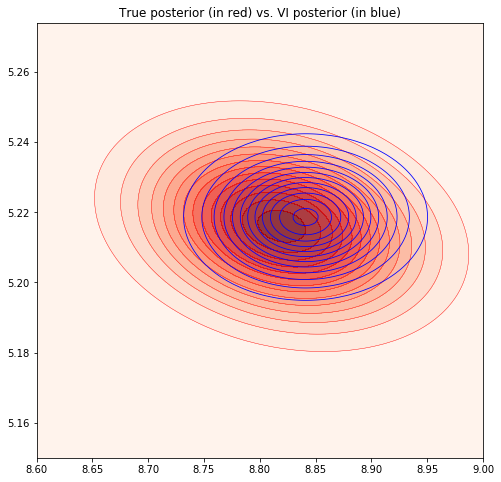

In [10]:
mu_VI = params[:D]
cov_VI = np.diag(np.exp(params[D:])**2)

x, y = numpy.mgrid[8.6:9:.001, 5.15:5.275:.001]
pos = numpy.dstack((x, y))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

z = scipy.stats.multivariate_normal(mu_post.flatten(), cov_post).pdf(pos)
z_VI = scipy.stats.multivariate_normal(mu_VI, cov_VI).pdf(pos)

ax.contourf(x, y, z, levels=14, cmap='Reds', alpha=0.8)
ax.contour(x, y, z, levels=14, linewidths=0.4, colors='red')

ax.contour(x, y, z_VI, levels=14, linewidths=0.8, colors='blue')
plt.title('True posterior (in red) vs. VI posterior (in blue)')

plt.show()

As expected, the true posterior $p$ has a slope due to the non-zero diagonals, something which our mean-field assumed $q$ could never capture. Additionally, there are two commonly experienced problems (Turner & Sahani, 2011):

- Under-estimation of the variance of the posterior. This is observed in the above plot where our $q$ is more concentrated.
- Biases in the MAP solution of parameters. This is observed in the above plot where our learned $\mu$ for $q$ does not coincide perfectly with the true $\mu$ for $p$.

These issues mean that the subsequent decisions we make using our VI solution could be biased and have incorrect uncertainty estimates. In fields such as medical operations, these could have dire consequences.

### Alternatives

There are a number of proposals for rich posterior approximations that have been explored, but there are some limitations :

- Structured mean-field : Instead of assuming fully factorized posteriors, this assumes that the distribution factorizes into a product of tractable distributions, such as trees or chains (Shukla, Shimazaki, & Ganguly, 2019). While this allows for the modeling of some correlations, the subsequent optimization becomes too complex for any realistic applications.
- Mixture model : This specifies the approximate posterior as a mixture model, and hence captures multi-modality well (Jordan et al., 1999). However, this limits the potential scalability of VI since it requires evaluation of the log-likelihood and its gradients for each mixture component per parameter update, which is typically computationally expensive.

### Normalizing Flows

A normalizing flow describes the transformation of a probability density through a series of invertible mappings, making the initial simple density 'flow' through the mappings and result in a more complex distribution (Tabak & Turner, 2013). These mappings can be shown to preserve the PDF normalization property : 

$$\int_\mathbf{z}q_k(\mathbf{z}_k)d\mathbf{z}_k = 1$$

at each stage $k$ of the flow, resulting in a valid density at the end.

We will consider the simple case of Planar flows, which introduces enough complexity in the approximate posterior $q$ for many applications. This uses an invertible and smooth mapping $f:\mathbb{R}^d \rightarrow \mathbb{R}^d$. If we use this to transform a random variable $\mathbf{z} \sim q(\mathbf{z})$, the resulting $\mathbf{z}^\prime = f(\mathbf{z})$ can be shown to be distributed as : 

$$q(\mathbf{z}^\prime) = q(\mathbf{z})\left|\det\frac{\partial f^{-1}}{\partial \mathbf{z}^\prime}\right| = q(\mathbf{z})\left|\det\frac{\partial f}{\partial \mathbf{z}^\prime}\right|^{-1}$$

Now, imagine applying this process multiple times to construct arbitrarily complex distributions. After $K$ such transformations on the initial $\mathbf{z}_0$, using the above equation, the resulting random variable 

$$\mathbf{z}_K = f_K\circ\cdots\circ f_1(\mathbf{z_0})$$

has log density

$$\log q_K(\mathbf{z}_K) = \log q_0(\mathbf{z}_0) - \sum_{k=1}^K \log\left|\det\frac{\partial f_k}{\partial \mathbf{z}_{k-1}}\right|$$

This path formed by the distributions $q_1,\cdots,q_K$ is called a <em>normalizing flow</em>. Using the law of the unconscious statistician (Blitzstein & Hwang, 2014), we are able to compute expectations using the transformed density $q_k$ without explicity knowing it : 

$$\mathbb{E}_{q_k}\left[h(\mathbf{z})\right] = \mathbb{E}_{q_0}\left[h\left(f_k\circ f_{k-1}\circ\cdots\circ f_1(\mathbf{z}_0)\right)\right]$$

Using this equation is one of the major innovations for using normalizing flows for VI, since we will need to eventually compute expectations under later flow distributions $q_k, k\in\{1,\cdots K\}$. However, since it is not always possible to sample $\mathbf{z}_k \sim q_k(\mathbf{z}_k)$ if $q_k$ becomes complex enough, this equation allows us to compute such expectations using $\mathbf{z}_0 \sim q_0$ where $q_0$ would be the simple starting distribution we select, e.g. an isotropic Gaussian.

Planar flows can be expressed as : 

$$f(\mathbf{z}) = \mathbf{z} + \mathbf{u}h(\mathbf{w}^\text{T}\mathbf{z} + b)$$

where the parameters $\lambda = \{\mathbf{w}\in\mathbb{R}^D, \mathbf{u}\in\mathbb{R}^D, b\in\mathbb{R}\}$ and $h$ is a smooth non-linearity that is chosen to be $tanh$ for this flow. Note that we can write the derivative of the $h(\mathbf{w}^\text{T}\mathbf{z} + b)$ term using chain rule as :

$$\psi(\mathbf{z}) = h^\prime(\mathbf{w}^\text{T}\mathbf{z} + b)\mathbf{w}$$

Hence using the matrix determinant lemma,

$$\left|\det\frac{\partial f}{\partial \mathbf{Z}}\right| = \left|\det\left(\mathbf{I} + \mathbf{u}\psi(\mathbf{z})^\text{T}\right)\right| = \left|1 + \mathbf{u}^\text{T}\psi(\mathbf{z})\right|$$


The log density from above can thus be expressed as 

$$\log q_K(\mathbf{z}_K) = \log q_0(\mathbf{z}_0) - \sum_{k=1}^K \log\left|1 + \mathbf{u}_k^\text{T}\psi_k(\mathbf{z}_{k-1})\right|$$

which only requires an analytical distribution expression for the simple $q_0$.

We can think of these Planar flows as a sequence of expansions and contractions on the initial density $q_0$. To visualize this process, we have built a D3.js app that allows the user to play around with the different flow parameters, getting a sense for not only what each of them do, but also the effect of coupling together multiple flows. Please find the app <a href="https://benlevyx.github.io/vi-normflows/app/" target="_blank">here</a>.

##### A screenshot of the app:

<img src="./fig/app.png" style="border:1px solid black;"></img>

### VI with Normalizing Flows 

This paper proposes a technique to implement VI using Normalizing Flows. The main ideas from the authors are : 
 - Specify the approximate posterior using normalizing flows that allows for construction of complex distributions by transforming a density through a series of invertible mappings. This provides a tighter, modified evidence lower bound (ELBO) with additional terms that have linear time complexity. This is in contrast with the alternative methods above which require more complex optimizations.
 - It can be shown that using VI with normalizing flows specifies a class of $q$ distributions that provide asymptotic guarantees, as opposed to naive mean-field VI.
 - This method is shown to systematically outperform other competing approaches for posterior approximation.
 
We will now provide deeper explanations of the above ideas. As an overview, we consider the general Variational Autoencoder (VAE) structure. A VAE is an unsupervised learning method that seeks to find a low-dimensional representation of usually high-dimensional data. For instance, if the observed data (denoted $\mathbf{X}$) is 100-dimensions, one might try to map those observed data into a latent space of 10 dimensions (where the latent variable is denoted $\mathbf{Z}$). This mapping is done through a simple neural network, called an **inference** or recognition network. Then, this latent representation $\mathbf{Z}$ can be used to generate new data by running the learned latent variables through a second neural network called a **generative** network. This process of mapping observed to latent variables and back to observed is characteristic of an autoencoder model. However, a **variational** autoencoder changes this paradigm. Rather than learning a single latent vector $\mathbf{z}_n$ for each observed vector $\mathbf{x}_n$, the inference network outputs the parameters of a **distribution** of possible $\mathbf{z}_n$'s for each $\mathbf{x}_n$. Typically, in order to make inference tractable, these parameters are the mean and variance of a diagonal gaussian. Another trick to optimize VAEs is **amortisation**. That is, rather than learning a set of $\mu$'s, $\sigma$'s, and flow parameters for each observation, we can instead notice that observed data points that are nearby in observed space should be similarly close in latent space. That means that we can instead learn a function $g_\phi(\mathbf{x})$, parameterised by $\phi$ that takes in observed data and outputs the mu, sigma, and flow parameters for those data. This is much computationall cheaper than the learning of explicit parameters for each data point. This amortisation is accomplished by the inference network itself. For more on variational autoencoders, see (Kingma & Welling, 2014) (https://arxiv.org/abs/1312.6114). This is summarized in the following (Pan, 2019): 

<table>
    <tr>
        <td>
            <img src="./fig/VAE_graphical.png" style="height:200px;" align="center">
        </td>
        <td>
            \begin{align}
            z_n &\sim p_\theta(z), \; \mathbf{(prior)}\\
            x_n &\sim p_\theta(x_n|z_n), \; \mathbf{(likelihood)}
            \end{align}
        </td>
    </tr>
</table>

Hence we need to : 

- Learn $f_\theta$, ***the generative network***, that will learn the mapping from latent variable $z_n$ to observed data $x_n$. Hopefully, we can learn to mimic the empirical distribution of observed data well.

- Learn $g_\phi$, ***the inference network***, that will learn the mapping from observed data $x_n$ to latent variable $z_n$. Hopefully, we can learn to infer the best approximation to the posterior $p(z_n|x_n)$ given an observation $x_n$.

These are summarized in the image below : 


<img src="./fig/trial.jpg" style="height:200px" align="center"/>


However, with normalizing flows, we can learn much more flexible families of distributions. This allows for more information to be encoded in otherwise highly compressed latent representations, meaning that we can potentially increase the ability of the autoencoder to faithfully reconstruct the observed data without sacrificing the compactnes and explainability of the latent representation. As per the standard variational formulation (Jordan et al., 1999), the marginal observed data likelihood can be bound as : 

$$\begin{aligned}
\log p_\theta (\mathbf{x}) &= \log \int p_\theta (\mathbf{x}|\mathbf{z})p(\mathbf{z})d\mathbf{z}\\
&= \log \int \frac{q_\phi(\mathbf{z}|\mathbf{x})}{q_\phi(\mathbf{z}|\mathbf{x})}p_\theta (\mathbf{x}|\mathbf{z})p(\mathbf{z})d\mathbf{z}\\
&\geq -\mathbb{D}_{\text{KL}}\left[q_\phi(\mathbf{z}|\mathbf{x}) \middle\| p(\mathbf{z})\right] + \mathbb{E}_{q_\phi(z|x)}\left[\log p_\theta (\mathbf{x}|\mathbf{z})\right]\\
&= \mathbb{E}_{q_\phi(z|x)}\left[\log p(\mathbf{x}, \mathbf{z}) - \log q_\phi(\mathbf{z}|\mathbf{x})\right]\\
&= -\mathcal{F}(\mathbf{x})
\end{aligned}$$

where we used Jensen's to obtain the inequality. We hence have to minimize this free energy $\mathcal{F}(\mathbf{x})$.

We now integrate this with our normalizing flows formulation. As per the diagram above, we parameterize the overall VAE approximate posterior with a flow of length $K$ :

$$q_\phi(\mathbf{z}|\mathbf{x}) := q_K(\mathbf{z}_K)$$

The free energy now becomes : 

$$\begin{aligned}
\mathcal{F}(\mathbf{x}) &= \mathbb{E}_{q_\phi(z|x)}\left[\log q_\phi(\mathbf{z}|\mathbf{x}) - \log p(\mathbf{x}, \mathbf{z})\right] \\
&= \mathbb{E}_{q_0(z_0)}\left[\log q_K(\mathbf{z}_K) - \log p(\mathbf{x}, \mathbf{z}_K)\right] \\
&= \mathbb{E}_{q_0(z_0)}\left[\log q_0(\mathbf{z}_0)\right] - \mathbb{E}_{q_0(z_0)}\left[\log p(\mathbf{x}, \mathbf{z}_K)\right]-\mathbb{E}_{q_0(z_0)}\left[\sum_{k=1}^K \log\left|1 + \mathbf{u}_k^\text{T}\psi_k(\mathbf{z}_{k-1})\right|\right]
\end{aligned}$$

where we used the normalizing flow log density derived above. We now have an objective function to minimize that only needs an analytical expression for the chosen simple distribution $q_0$, an analytical expression for the joint likelihood $p$ that depends on our model and the various flow parameters $\lambda$ that we want to learn. The generative network parameters $\theta$ are a part of the likelihood $p$ while the inference network parameters $\phi$ are the flow parameters $\lambda$ which is a part of the final summation term. We can also opt to learn the optimal parameters of the initial distribution $q_0$, which would be a part of the first term. Hence, optimizing $\mathcal{F}$ should allow us to learn the optimal $\theta, \phi$ as needed in VAEs. All the expectations can be computed using Monte Carlo estimation with $\mathbf{z}_0 \sim q_0$, something that we can easily sample. We are thus able to minimize the objective using any optimization package.

### Results
#### Estimating $\phi$

We first consider the simpler case where we have no observed data, and just wish to approximate an arbitrarily complex posterior that we can analytically define. 

*1D Case*

We can first try this approach on a simple mixture of Gaussians that are close together.

In [2]:
def gmm(z):
    gauss_uni = lambda x, mu, sigma: 1/np.sqrt(2*np.pi*sigma**2) * np.exp(-0.5*((x-mu)/sigma)**2)
    pi = np.array([0.3, 0.7])
    mu = np.array([-1.5, 1.5])
    sigma = np.array([1 , 1])
    return pi[0]*gauss_uni(z, mu[0], sigma[0]) + pi[1]*gauss_uni(z, mu[1], sigma[1])

The code for the optimization is below:

In [ ]:
m = lambda x: -1 + np.log(1 + np.exp(x))
h = lambda x: np.tanh(x)
h_prime = lambda x: 1 - np.tanh(x)**2


def gradient_create(target, eps, dim_z, num_samples, K):

    def unpack_params(params):
        W = params[:K*dim_z].reshape(K,dim_z)
        U = params[K*dim_z:2*K*dim_z].reshape(K,dim_z)
        B = params[-K:]
        return W,U,B

    def variational_objective(params, t):
        """Provides a stochastic estimate of the variational lower bound."""
        W,U,B = unpack_params(params)
        z0 = np.random.multivariate_normal(np.zeros(dim_z), np.eye(dim_z),
                num_samples)
        z_prev = z0
        sum_log_det_jacob = 0.
        for k in range(K):
            w, u, b = W[k], U[k], B[k]
            u_hat = (m(np.dot(w,u)) - np.dot(w,u)) * (w / np.linalg.norm(w)) + u
            affine = np.outer(h_prime(np.matmul(z_prev, w) + b), w)
            sum_log_det_jacob += np.log(eps + np.abs(1 + np.matmul(affine, u)))
            z_prev = z_prev + np.outer(h(np.matmul(z_prev, w) + b), u_hat)
        z_K = z_prev
        log_q_K = -0.5 * np.sum(np.log(2*np.pi) + z0**2, 1) - sum_log_det_jacob
        log_p = np.log(eps + target(z_K))
        return np.mean(log_q_K - log_p)

    gradient = grad(variational_objective)

    return variational_objective, gradient, unpack_params

def optimise(func, num_samples, num_iter, lr, K, dim_z=2):

    objectives = []
    objective, gradient, unpack_params = gradient_create(func, 1e-7, dim_z, num_samples, K)
    init_W = 0.1*np.ones((K, dim_z))
    init_U = 0.1*np.ones((K, dim_z))
    init_b = 0.1*np.ones((K))
#     init_W = np.random.randn(K, dim_z)
#     init_U = np.random.randn(K, dim_z)
#     init_b = np.random.randn(K)
    init_params = np.concatenate((init_W.flatten(), init_U.flatten(), init_b.flatten()))
    
    def callback(params, t, g):
        if t%100 == 0:
            print("Iteration {}; Gradient mag: {}; Objective: {}".format(t,
                np.linalg.norm(gradient(params, t)), objective(params, t)))
            objectives.append(objective(params, t))
        if t%5000 == 0:
            W, U, B = unpack_params(params)
            z0 = np.random.randn(num_samples, dim_z)
            z_prev = z0
            for k in range(K):
                w, u, b = W[k], U[k], B[k]
                u_hat = (m(np.dot(w,u)) - np.dot(w,u)) * (w / np.linalg.norm(w)) + u
                z_prev = z_prev + np.outer(h(np.matmul(z_prev, w) + b), u_hat)
            z_K = z_prev
            plt.figure(figsize=(5,4))
            if dim_z==1:
                plt.hist(z_K, 20, density=True)
            else:
                plt.scatter(z_K[:,0], z_K[:,1])
                plt.xlim([-4,4])
                plt.ylim([-4,4])
            plt.show()

    variational_params = rmsprop(gradient, init_params, callback, num_iter, lr)
    
    return variational_params, objectives

def visualise_loss(objectives):
    
    plt.figure(figsize=(10,8))
    plt.plot(objectives)
    plt.xlabel('Iterations (100s)')
    plt.ylabel('Free Energy')
    plt.title('Free energy during optimization')
    plt.show()

def visualise_flow(func, variational_params, K, num_iter, todo='show', dim_z=2, xlimits=[-4,4], ylimits=[-4,4]):
   
    def unpack_params(params):
        W = params[:K*dim_z].reshape(K,dim_z)
        U = params[K*dim_z:2*K*dim_z].reshape(K,dim_z)
        B = params[-K:]
        return W,U,B
    
    W, U, B = unpack_params(variational_params)
    z0 = np.random.randn(1000, dim_z)
    z_prev = z0
    for k in range(K):
        w, u, b = W[k], U[k], B[k]
        u_hat = (m(np.dot(w,u)) - np.dot(w,u)) * (w / np.linalg.norm(w)) + u
        z_prev = z_prev + np.outer(h(np.matmul(z_prev, w) + b), u_hat)
    z_K = z_prev
    
    if dim_z == 1:
        plt.figure(figsize=(10,8))
        samples = np.linspace(xlimits[0], xlimits[1], 1401)
        z = np.array([func(samples[i]) for i in range(samples.shape[0])])
        idx = np.argsort(samples)
        plt.plot(samples[idx], z[idx], label='True Density')
        plt.hist(z_K, 50, label='Approximated Density', density=True)
        plt.title('GMM using K={}'.format(K))
        plt.legend()
        
    else:
        fig, ax = plt.subplots(1,1, figsize=(10,8))

        nbins = 100
        x, y = z0[:, 0], z0[:, 1]
        xi, yi = numpy.mgrid[-4:4:nbins*1j, -4:4:nbins*1j]
        zi = np.array([func(np.vstack([xi.flatten(), yi.flatten()])[:,i].reshape(-1,2)) for i in range(nbins**2)])
        ax.pcolormesh(xi, yi, zi.reshape(xi.shape))
        ax.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.Reds_r)
        ax.scatter(z_K[:,0], z_K[:,1], alpha=0.2)
        ax.set_xlim(xlimits)
        ax.set_ylim(ylimits)
    
    if todo=='show':
        plt.show()
    else:
        plt.savefig('results/'+func.__name__+'/'+func.__name__+'_'+str(K)+'_'+str(num_iter)+'.png')

We run the optimization and view the results. Since this is a simple case, $K=1$ flows should be enough.

Iteration 0; Gradient mag: 2.8168171135552598; Objective: 1.3152850306717563


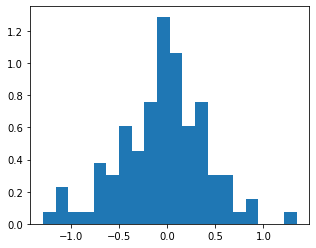

Iteration 100; Gradient mag: 2.731058190913353; Objective: 1.0376212707594274
Iteration 200; Gradient mag: 2.2244046687237837; Objective: 0.8462612154058646
Iteration 300; Gradient mag: 1.985831789845909; Objective: 0.7325385858061721
Iteration 400; Gradient mag: 1.8152945271575673; Objective: 0.5205190408318664
Iteration 500; Gradient mag: 1.565812668887342; Objective: 0.392114052065005
Iteration 600; Gradient mag: 1.4518412249840629; Objective: 0.21274812107512076
Iteration 700; Gradient mag: 1.2488212540890722; Objective: 0.3152039900620713
Iteration 800; Gradient mag: 0.9988893067091799; Objective: 0.2432441710166139
Iteration 900; Gradient mag: 0.854407299611456; Objective: 0.25754898326692616
Iteration 1000; Gradient mag: 0.859156530748414; Objective: 0.04118451595947662
Iteration 1100; Gradient mag: 0.7737421569435124; Objective: 0.00017977866883706498
Iteration 1200; Gradient mag: 0.7547551016406601; Objective: 0.11526170969096151
Iteration 1300; Gradient mag: 0.522689571404933

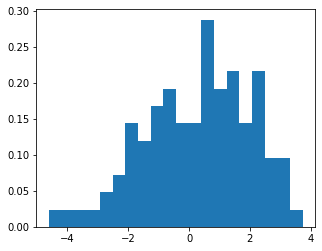

Iteration 5100; Gradient mag: 0.032839946185376355; Objective: -0.22161252943596352
Iteration 5200; Gradient mag: 0.12660541084455176; Objective: -0.22880368337932078
Iteration 5300; Gradient mag: 0.0065005437423022614; Objective: -0.2534366424862026
Iteration 5400; Gradient mag: 0.09214534724787482; Objective: -0.2367426079023315
Iteration 5500; Gradient mag: 0.10628681640059266; Objective: -0.2581244696038082
Iteration 5600; Gradient mag: 0.05191421850304159; Objective: -0.22446839285469947
Iteration 5700; Gradient mag: 0.07204600345055116; Objective: -0.23535800354222716
Iteration 5800; Gradient mag: 0.0859720355440043; Objective: -0.250758103429544
Iteration 5900; Gradient mag: 0.11176152636507786; Objective: -0.2181442676303983
Iteration 6000; Gradient mag: 0.07037928638043252; Objective: -0.2286992238868777
Iteration 6100; Gradient mag: 0.07434521232429442; Objective: -0.22783098530889612
Iteration 6200; Gradient mag: 0.06928415028898466; Objective: -0.23478625304881548
Iteration

In [5]:
K = 1
dim_z = 1
num_samples = 100
num_iter = 7000
func = gmm
lr=5e-4

variational_params, objectives = optimise(func, num_samples, num_iter, lr, K, 1)

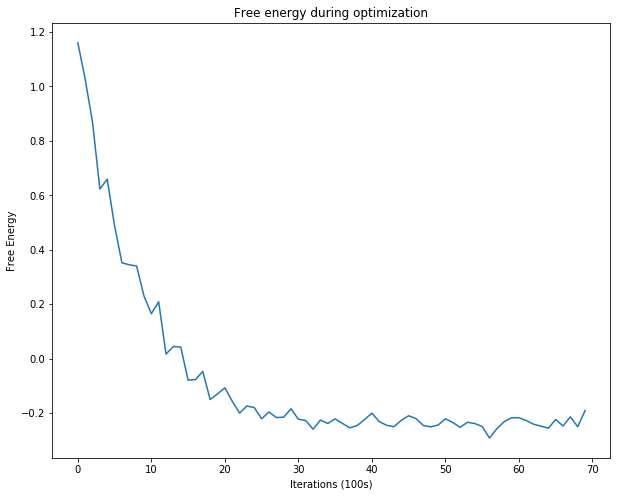

In [6]:
visualise_loss(objectives)

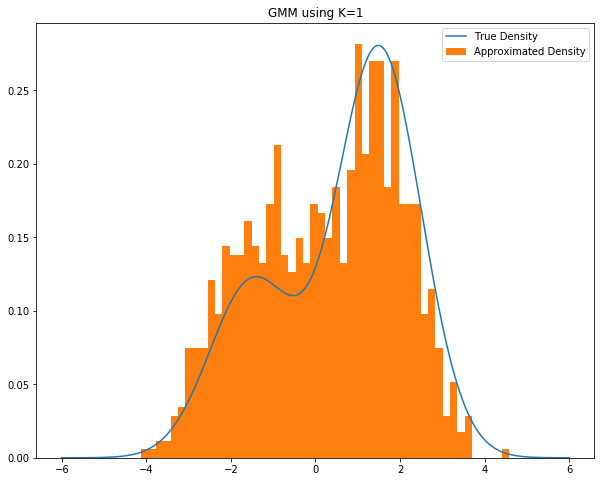

In [7]:
visualise_flow(func, variational_params, K, num_iter, todo='show', dim_z=1, xlimits=[-6,6])

Let us try another case with a more spread out mixture.

In [8]:
def gmm1(z):
    gauss_uni = lambda x, mu, sigma: 1/np.sqrt(2*np.pi*sigma**2) * np.exp(-0.5*((x-mu)/sigma)**2)
    pi = np.array([0.3, 0.7])
    mu = np.array([-3, 3])
    sigma = np.array([1 , 1])
    return pi[0]*gauss_uni(z, mu[0], sigma[0]) + pi[1]*gauss_uni(z, mu[1], sigma[1])

Iteration 0; Gradient mag: 0.9550148408127535; Objective: 2.076885708095291


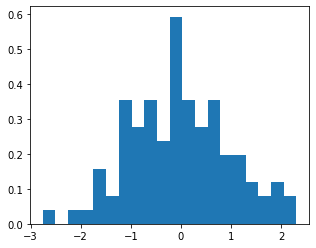

Iteration 100; Gradient mag: 0.904026795111821; Objective: 2.349837816277725
Iteration 200; Gradient mag: 0.9168648811526569; Objective: 2.1906080700594446
Iteration 300; Gradient mag: 0.9699075751620776; Objective: 2.3633330034059514
Iteration 400; Gradient mag: 0.9920345316835509; Objective: 1.7682301687208863
Iteration 500; Gradient mag: 0.9353304938499892; Objective: 1.9708286149936838
Iteration 600; Gradient mag: 0.9727126950114421; Objective: 2.160977575767292
Iteration 700; Gradient mag: 0.9824673834053179; Objective: 1.5653185652303572
Iteration 800; Gradient mag: 1.0664347662419094; Objective: 1.6251135712795397
Iteration 900; Gradient mag: 0.9789007443166845; Objective: 1.6917525756200957
Iteration 1000; Gradient mag: 1.0336012435601336; Objective: 1.5876189285157376
Iteration 1100; Gradient mag: 1.0032041738799455; Objective: 1.4382291509800678
Iteration 1200; Gradient mag: 1.059252491329309; Objective: 1.8487152431239473
Iteration 1300; Gradient mag: 1.0859263468913496; Obj

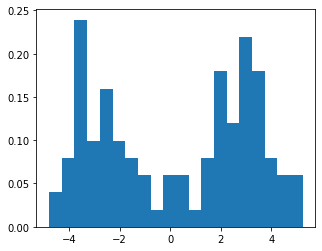

Iteration 5100; Gradient mag: 0.07571038841965329; Objective: -0.035044747945506466
Iteration 5200; Gradient mag: 0.22483542066300752; Objective: 0.04646794134929822
Iteration 5300; Gradient mag: 0.19442393431289878; Objective: -0.013017417477100593
Iteration 5400; Gradient mag: 0.05356017924555477; Objective: 0.06228642354250807
Iteration 5500; Gradient mag: 0.05023973096598694; Objective: 0.08070626242967843
Iteration 5600; Gradient mag: 0.30542277069579843; Objective: -0.07666634861528665
Iteration 5700; Gradient mag: 0.18915191365092537; Objective: -0.00748340133843318
Iteration 5800; Gradient mag: 0.12932484396167; Objective: 0.1340652089419126
Iteration 5900; Gradient mag: 0.2484714304595271; Objective: 0.11834260343896094
Iteration 6000; Gradient mag: 0.17110977622131485; Objective: -0.006210015748285718
Iteration 6100; Gradient mag: 0.12410066586553485; Objective: -0.01906039975356215
Iteration 6200; Gradient mag: 0.16195005226666748; Objective: 0.05518124665528385
Iteration 63

In [9]:
func = gmm1

variational_params, objectives = optimise(func, num_samples, num_iter, lr, K, 1)

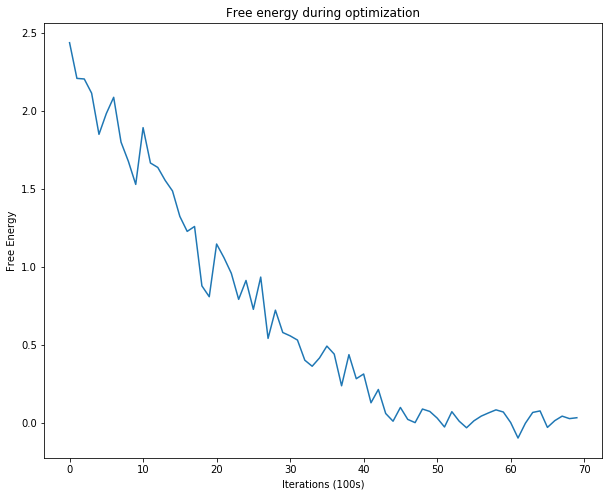

In [10]:
visualise_loss(objectives)

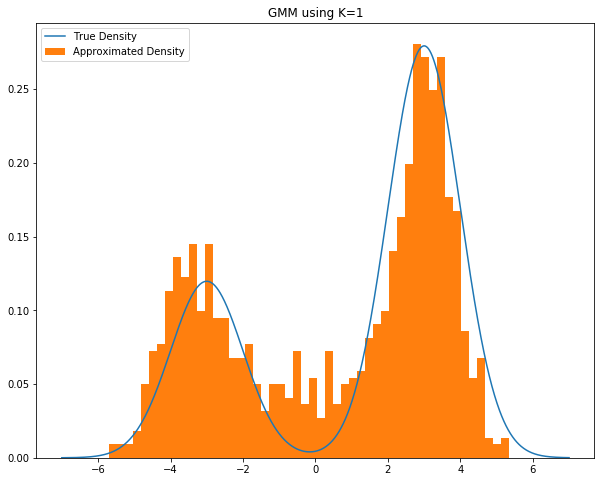

In [14]:
visualise_flow(func, variational_params, K, num_iter, todo='show', dim_z=1, xlimits=[-7,7])

We see that it captures the unequal bimodality decently well both times using just $K=1$.

*2D Case*

The paper considers the following potentials for bivariate $\mathbf{z}$ : 

$$\begin{aligned}
U_1(\mathbf{z}) &= \frac{1}{2}\left(\frac{\left\lVert\mathbf{z}\right\rVert -2}{0.4}\right)^2 - \log\left[e^{-\frac{1}{2}\left(\frac{\mathbf{Z}_1-2}{0.6}\right)^2} + e^{-\frac{1}{2}\left(\frac{\mathbf{Z}_1+2}{0.6}\right)^2}\right]\\
U_2(\mathbf{z}) &= \frac{1}{2}\left(\frac{\mathbf{z}_2 -w_1(\mathbf{z})}{0.4}\right)^2\\
\end{aligned}$$

where

$$\begin{aligned}
w_1(\mathbf{z}) &= \sin\left(\frac{2\pi\mathbf{z}_1}{4}\right)
\end{aligned}$$

and where the distribution $p(\mathbf{z}) \propto e^{-U(\mathbf{z})}$. We visualise these below.

In [16]:
sigmoid = lambda x: 1/(1+np.exp(-x))
w1 = lambda x: np.sin(2 * np.pi * x/4)
w2 = lambda x: 3*np.exp(-0.5*((x-1)/0.6)**2)
w3 = lambda x: 3*sigmoid((x-1)/0.3)

def trial1(z):
    if len(z.shape)>1:
        z1, z2 = z[:, 0], z[:, 1]
    else:
        z1, z2 = z[0], z[1]
    norm = np.sqrt(z1 ** 2 + z2 ** 2)
    exp1 = np.exp(-0.5 * ((z1 - 2) / 0.8) ** 2)
    exp2 = np.exp(-0.5 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - np.log(exp1 + exp2)
    return np.exp(-u)        

def p1(z):
    '''Apply posterior p_1 to bivariate z.'''
    if len(z.shape)>1:
        z1, z2 = z[:, 0], z[:, 1]
        first = (np.linalg.norm(z, 2, 1) - 2)/0.4
        exp1 = np.exp(-0.5*((z1 - 2)/0.6)**2)
        exp2 = np.exp(-0.5*((z1 + 2)/0.6)**2)
        u = 0.5*first**2 - np.log(exp1 + exp2)
        return np.exp(-u)
    else:
        first = (np.linalg.norm(z)-2)/0.4
        second = np.exp(-0.5*((z[0] - 2)/0.6)**2)
        third = np.exp(-0.5*((z[0] + 2)/0.6)**2)
        return np.exp(-0.5*first**2 + np.log(second+third))

def p2(z):
    '''Apply posterior p_2 to bivariate z.'''
    if len(z.shape)>1:
        z1, z2 = z[:, 0], z[:, 1]
        u = 0.5 * ((z2 - w1(z1))/0.4) ** 2
        dummy = np.ones(u.shape) * 1e7
        u = np.where(np.abs(z1) <= 4, u, dummy)
        return np.exp(-u)
    else:
        first = (z[1] - w1(z[0]))/0.4
        return np.exp(-0.5*first**2)

def p3(z):
    '''Apply posterior p_3 to bivariate z.'''
    if len(z.shape)>1:
        z1, z2 = z[:, 0], z[:, 1]
        exp1 = np.exp(-0.5*((z2 - w1(z1))/0.35)**2)
        exp2 = np.exp(-0.5*((z2 - w1(z1) + w2(z1))/0.35)**2)
        u = - np.log(exp1 + exp2)
        return np.exp(-u)
        
    else:
        first = np.exp(-0.5*((z[1] - w1(z[0]))/0.35)**2)
        second = np.exp(-0.5*((z[1] - w1(z[0]) + w2(z[0]))/0.35)**2)
        return first+second

def p4(z):
    '''Apply posterior p_4 to bivariate z.'''
    if len(z.shape)>1:
        z1, z2 = z[:, 0], z[:, 1]
        exp1 = np.exp(-0.5*((z2 - w1(z1))/0.4)**2)
        exp2 = np.exp(-0.5*((z2 - w1(z1) + w3(z1))/0.35)**2)
        u = - np.log(exp1 + exp2)
        return np.exp(-u)
    else:
        first = np.exp(-0.5*((z[1] - w1(z[0]))/0.4)**2)
        second = np.exp(-0.5*((z[1] - w1(z[0]) + w3(z[0]))/0.35)**2)
        return first+second

In [19]:
ndim = 2
mu0 = np.zeros(ndim)
Sigma0 = np.eye(ndim)
N = 1000

samples = np.random.multivariate_normal(mu0, Sigma0, size=N)

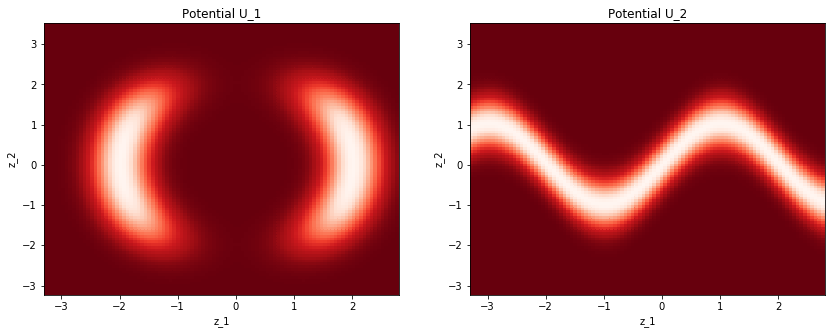

In [21]:
fig,ax=plt.subplots(1,2,figsize = (14,5))
nbins = 100
x, y = samples[:, 0], samples[:, 1]
xi, yi = numpy.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]

zi = np.array([p1(np.vstack([xi.flatten(), yi.flatten()])[:,i]) for i in range(nbins**2)])
ax[0].pcolormesh(xi, yi, zi.reshape(xi.shape))
ax[0].pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.Reds_r)
ax[0].set_xlabel('z_1')
ax[0].set_ylabel('z_2')
ax[0].set_title('Potential U_1')

zi = np.array([p2(np.vstack([xi.flatten(), yi.flatten()])[:,i]) for i in range(nbins**2)])
ax[1].pcolormesh(xi, yi, zi.reshape(xi.shape))
ax[1].pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.Reds_r)
ax[1].set_xlabel('z_1')
ax[1].set_ylabel('z_2')
ax[1].set_title('Potential U_2')

plt.show()

We show the best results for both potentials below:

Potential $U_1$            |  Potential $U_2$
:-------------------------:|:-------------------------:
![](./results/p1/p1_8_50000.png)  |  ![](./results/p2/p2_16_60000.png)

As seen, the posteriors are captured relatively well, meaning that VI with normalizing flows is in general a good technique for capturing complex posteriors. We would expect that using more flows would allow for more complexity in $q(\mathbf{z})$ and hence a better fit. We can inspect the impact of flow lengths on the variational objective $\mathcal{F}(\mathbf{x})$ and log likelihood $\log p(\mathbf{x})$ for the potential $U_1$. These are summarized below:

<img src="./fig/values_against_K.png"></img>

This would seem to indicate that using more flows allows for better fitting of the true posterior. However, there is flow collapse observed sometimes at high $K$ values, and this is discussed in the `Failure Modes` section below. Hence, simply inspecting the free energy value during training is not always a good measure of fitting. We found that visualizing the actual flow during training was an important tool to work out optimal parameters, as shown in our `optimise` function above. Some other problems with using normalizing flows are summarized in the `Failure Modes` section below.

#### Estimating $\phi,\theta$

We now focus on the case where we have real data and we are trying to estimate both encoding and decoding parameters. We built a variational autoencoder (VAE) that incorporates normalizing flows to replicate the experiment done by the authors on the MNIST dataset.

*Dataset*

The MNIST dataset is a set of 60,000 training images and 10,000 test images, each of which is a $28\times 28$ pixel handwritten grayscale image of a digit from 0 to 9 (LeCun & Cortes, 1998). Like the authors, we used a binarized version of the dataset, where all pixels with a luminance value 128 or above (half of the maximum luminance) were classified as 1 and those below were classified as 0.

In order to simplify the task for paedagogical purposes, we limited the dataset to include only 0's, 1's, 4's, and 7's.

*Architecture*

Rezende & Mohamed employ a VAE that uses a simple neural network as the inference network and what is known as a Deep Latent Gaussian Model (DLGM) as the generative network. Whereas the inference network's role is to learn the parameters of the variational distribution $q_\phi(\mathbf{z})$ and the flow parameters for each data point, the role of the DLGM is to learn the parameters of the likelihood $p_\theta(\mathbf{x}|\mathbf{z})$. This likelihood is important because it shows up in the free energy (mentioned above) as part of the joint probability $p(\mathbf{x}, \mathbf{z})$.

For the inference network, we used a neural network with 3 hidden layers, a hidden layer width of 64, and a ReLu activation function. The output of this network, for each observation, was the mean and log-variance (diagonal) of the latent distributions, as well as the flow parameters. The dimension of the latent variable was 40, as employed by the authors. To examine the effect of flow length on the optimization, we varied the number of flows, using 1, 4, 8, 16, and 32 flows.

For the generative network, we used a neural network that was nearly the inverse of the inference network. It had 3 hidden layers, a hidden layer width of 64, and ReLu activation functions. The ouptut layer had an additional sigmoid activation function such that all outputs would be valid probabilities (constrained between 0 and 1) for use in the Bernoulli likelihood.

We trained the model on a 2000-image sample of the MNIST training data with a batch size of 128 and step size of 0.001 using autograd's Adam optimizer. In order to simplify the replication, we use a simpler neural network as a generative model. This neural network maps from latent variables $\mathbf{z}$ to the parameters of the likelihood function. Because each pixel in the MNIST dataset is either 0 or 1, the likelihood function is a Bernoulli distribution parameterised by a probability from 0 to 1.

*Effect of flow length on free energy*

<img src="./figures/free_energy.png"></img>

This figure shows free energy (variational objective) versus increasing flow length. We were unable to observe the same effect as seen in the Rezende & Mohamed paper, likely due to the fact that the authors used highly optimized architectures that were run for vastly more iterations (total 500,000), with several hundred restarts, which we were unfortunately unable to do due to time constraints. However, this free energy closely tracks with the fidelity of the reconstructed images (lower free energy correlates with better image reconstructions). In our case, the model with 2 flows performed best.

*Image reconstruction*

The core task of an autoencoder is being able to reconstruct an image from only its latent representation. For the following experiments, since the emphasis is on qualitative over quantitative evaluation, we reduced the latent embedding from 40 variables to 2, allowing for the latent distributions to be more easily explored. One issue with the more compressed embedding is that the parameters of the gradient became numerically unstable at K=16 flows (whereas at 40 latent variables instability only became a problem at K=32 flows). As a result, here we show flows of length K=1, 2, 4, and 8.

First, we visually investigated the effect of progressively longer flows on the ability of the VAE to faithfully reconstruct images, as can be seen here:

<img src="./figures/digit_reconstruction.png"></img>

This figure shows how models with different flows are able to reconstruct the original handwritten digit. The added flexibility from K=1 to 2 shows a clear improvement, whereas the improvement from K=4 to 8 is more marginal, as was also seen in the original paper.

*Latent space flexibility*

The added fidelity of the image reconstructions presumably arises due to the additional flexibility of the normalizing flows. Here we can see how the shape of the latent distributions changes from close to spherical to more diagonal when we look at the two dimensions of the latent space:

<img src="./figures/digit_latent.png"></img>

Clearly, we are no longer working with isotropic gaussians!

*Mapping the latent space*

Finally, we can sample from a uniform grid across a 2-dimensional latent space (separate model from those above) and put those through the generative model to see different regions that would correspond to different digits. Although we did not explicitly test for clustering and digit classification, this gives us an idea of how successful such a model would be at this task:

<img src="./figures/latent_grid.png"></img>

The code to run the optimization can be found [here](https://github.com/benlevyx/vi-normflows/blob/master/src/learning_mnist.py) and the notebook to generate the figures can be found [here](https://github.com/benlevyx/vi-normflows/blob/master/notebooks/2_basic_optimization/2_mnist.ipynb)

#### Failure Modes

We now outline the various types of tasks that we found this method does not perform well in.

1. For multi-modal posteriors, we found that there was a strong tendency for the flows to collapse onto one of the modes, and get increasingly concentrated at that mode to minimize the free energy further. We show an example with the potential $U_1$ (two beans) from before. As seen, the algorithm picks the left mode and collapses on it, becoming more spiked at the middle of the bean.


Iteration 6000             |  Iteration 10000
:-------------------------:|:-------------------------:
![](./results/p1/p1_8_10000.png)  |  ![](./results/p1/p1_8_10000_2.png)

Here we show another example, with a collapse on the right bean. The mode it selects was found to be purely dependent on the initialization, as expected.

<img src="./results/p1/p1_4_20000_2.png" style="height:400px" align="center"/>

2. We found that the flows collapsed sometimes when a higher than needed $K$ was used. For example, with the same potential $U_1$ from above, $K=8$ was generally sufficient to get good results. However, when a higher $K=16$ was used, instead of getting a better fit, we found that the flow just collapsed onto a small region as shown below. We propose that this was because the flow had too much flexibility at high $K$ and could hence model such a collapse. Since this small region in the center of the bean had high probability mass, it was optimal for the samples to converge there, which is confirmed by the free energy continually decreasing during training. In fact, the free energy at the end of this collapsed training was much better than the optimal results we found above. Since the free energy $\mathcal{F}(\mathbf{x}) = \mathbb{E}_{q_\phi(z|x)}\left[\log q_\phi(\mathbf{z}|\mathbf{x}) - \log p(\mathbf{x}, \mathbf{z})\right]$, this means that the collapsed flow was actually a 'better fit' in terms of this approximated KL-divergence. To prevent such degenerate cases, we propose that some modification of the free energy might be needed that penalizes such collapses (e.g. penalize the variance of $\mathbf{z}_K$ from getting too low). 


Collapse at $K=16$         |  Free Energy during Training
:-------------------------:|:-------------------------:
![](./results/p1/p1_16_40000_2.png)  |  ![](./results/p1/collapse_curve.png)

3. In terms of the VAE model, the added flexibility came at both a computational cost (more parameters to train) and a cost in terms of variance: 

First, the computational cost: The parameters of the flow are the outputs of the inference network and most reasonable automatic differentiation packages use the reverse mode of automatic differentiation. However, the reverse mode scales linearly in terms of the number of outputs of the function, meaning that for each additional flow, we need to add $2 \times dim_z \times N + N$ passes through the neural net.

Second, the cost of variance: since the VAE is bayesian, we are not mapping each observation to a discrete vector in the latent space. Rather, we are mapping each observation to a distribution of latent vectors and then sampling from that distribution. Thus, if that distribution becomes overly flexible, with many modes and other irregularities, there is the risk that any given observation might have very high variance in terms of its reconstruction error. We noticed this when running the MNIST experiments: when we used the 40-dimensional latent variable as employed by Rezende & Mohamed, the resulting reconstructed images were nearly always very noisy. But when we decreased the number of dimensions to 2, the reconstructed images were much more likely to be faithful to the original. This could possibly be due to the model failing to reach an optimum with more parameters. However, the higher amount of space to sample from in higher dimensions also likely causes the samples to be more inconsistent, especially when the distributions deviate significantly from an isotropic gaussian due to the normalizing flow.

### Conclusion

In conclusion, VI with normalizing flows provides an elegant way of overcoming the limitations of naive mean-field VI by providing a mechanism for introducing complexity into the approximate posterior $q(\mathbf{z}|\mathbf{x})$. By using relevant probability laws, we are able to express the final objective function with just an analytical expression for the chosen simple distribution $q_0$, an analytical expression for the joint likelihood $p$ that depends on our model and the various flow parameters $\lambda$ that we want to learn. This allows us to use simple gradient-descent based optimizers to learn the optimal flows. We found that the method performed well in capturing complex posteriors, both in the absence and presence of real data. However, sometimes tedious tuning is required before good results are obtained, especially with the tendency for the flows to collapse when there is multimodality or a high $K$ is used. Despite this, we argue that normalizing flows is still a good framework to consider when performing variational inference. It allows for the capture of complex posteriors, something that sampling techniques would tend to fail at (especially with multimodality). Additionally, from our flows applet above, it can be seen that it allows for interpretable results, since the parameters $\lambda$ have geometric interpretations when it comes to how they influence the flows.

### References
1. Turner, R. E. and Sahani, M. Two problems with variational expectation maximisation for time-series models. In Barber, D., Cemgil, T., and Chiappa, S. (eds.), <em>Bayesian Time series models</em>, chapter 5, pp. 109–130. Cambridge University Press, 2011.

2. Shukla, S., Shimazaki, H., & Ganguly, U. Structured Mean-field Variational Inference and Learning in Winner-take-all Spiking Neural Networks, 2019.

3. Jordan, M. I., Ghahramani, Z., Jaakkola, T. S., and Saul, L. K. An introduction to variational methods for graphical models. <em>Machine learning</em>, 37(2):183–233, 1999.

4. Tabak, E. G. and Turner, C. V. A family of nonparametric density estimation algorithms. <em>Communications on Pure and Applied Mathematics</em>, 66(2):145–164, 2013.

5. Blitzstein, J. K., & Hwang, J. Introduction to Probability (1st ed.). <em>Chapman and Hall</em>, pp. 156, 2014.

6. Pan, W. Lecture 19: Kalman Filters. <em>Harvard Applied Math 207</em>, Fall 2019.

7. Kingma, D. P. and Welling, M. Auto-encoding variational Bayes. In *ICLR*, 2014.

8. LeCun, Y. and Cortes, C. The MNIST database of hand-written digits, 1998.